<a href="https://colab.research.google.com/github/ASHIKAMOHAN/Sales_Forecasting/blob/main/sales_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [ ]:

file_path = '/content/drive/MyDrive/ML Data 3.csv'
df = pd.read_csv(file_path)

print(df)
print(df.shape)

          Rows No  Location ID    DealDate Currency Type  Type  Amount  \
0        28937647          140  04/01/2022      JMD    N     S   77000   
1        28937648          140  04/01/2022      XCD    N     S    1000   
2        28937649          140  04/01/2022      KRW    N     S  910000   
3        28937650          140  04/01/2022      EUR    N     S     705   
4        28937651          140  04/01/2022      TRY    N     S    3215   
...           ...          ...         ...      ...  ...   ...     ...   
8234155  46696722           38  30/04/2025      EUR    N     S     335   
8234156  46696723           38  30/04/2025      EUR    N     B     200   
8234157  46696724           38  30/04/2025      EUR    N     S     100   
8234158  46696725           38  30/04/2025      JPY    N     S   27000   
8234159  46696726          272  29/04/2025      EUR    N     S     340   

          Value  OriginationID  OrderTypeID  Reatils rate  
0        401.68              2            2      19

In [ ]:
# Step 1: Clean column names
df.columns = df.columns.str.strip()


In [ ]:
# Step 2: Display all columns to inspect the order
print("Original Columns:", df.columns.tolist())


Original Columns: ['Rows No', 'Location ID', 'DealDate', 'Currency', 'Type', 'Type', 'Amount', 'Value', 'OriginationID', 'OrderTypeID', 'Reatils rate']


In [ ]:
# Step 3: Rename both 'Type' columns manually by index
df.columns.values[4] = 'Currency Type'  # This should be the first 'Type'
df.columns.values[5] = 'Txn Type'       # This should be the second 'Type'


In [ ]:
# Step 4: Confirm renaming worked
print("Renamed Columns:", df.columns.tolist())


Renamed Columns: ['Rows No', 'Location ID', 'DealDate', 'Currency', 'Currency Type', 'Txn Type', 'Amount', 'Value', 'OriginationID', 'OrderTypeID', 'Reatils rate']


In [ ]:
# Step 5: Clean values in 'Txn Type'
df['Txn Type'] = df['Txn Type'].astype(str).str.strip()


In [ ]:
# Step 6: Check unique values
print("Txn Type Unique Values:", df['Txn Type'].unique())


Txn Type Unique Values: ['S' 'B']


In [ ]:
# Step 7: Filter for sales
df = df[df['Txn Type'] == 'S']
print("Filtered DataFrame shape:", df.shape)


Filtered DataFrame shape: (5847039, 11)


In [ ]:
# Step 8: Preview data
print(df.head())

    Rows No  Location ID    DealDate Currency Currency Type Txn Type  Amount  \
0  28937647          140  04/01/2022      JMD             N        S   77000   
1  28937648          140  04/01/2022      XCD             N        S    1000   
2  28937649          140  04/01/2022      KRW             N        S  910000   
3  28937650          140  04/01/2022      EUR             N        S     705   
4  28937651          140  04/01/2022      TRY             N        S    3215   

    Value  OriginationID  OrderTypeID  Reatils rate  
0  401.68              2            2      191.6949  
1  293.17              2            2        3.4110  
2  603.05              2            2     1508.9959  
3  601.54              2            2        1.1720  
4  200.15              2            2       16.0630  


In [ ]:
# Convert DealDate to datetime
df['DealDate'] = pd.to_datetime(df['DealDate'], dayfirst=True)


In [ ]:
# Step 2: Aggregate Daily Sales per Branch
daily_sales = df.groupby(['DealDate', 'Location ID'])['Value'].sum().reset_index()
daily_sales.rename(columns={'Value': 'DailySales'}, inplace=True)


In [ ]:
# Step 3: Feature Engineering
daily_sales['dayofweek'] = daily_sales['DealDate'].dt.dayofweek
daily_sales['month'] = daily_sales['DealDate'].dt.month
daily_sales['year'] = daily_sales['DealDate'].dt.year
daily_sales['lag_1'] = daily_sales.groupby('Location ID')['DailySales'].shift(1)
daily_sales['rolling_mean_7'] = daily_sales.groupby('Location ID')['DailySales'].shift(1).rolling(7).mean()
daily_sales.dropna(inplace=True)


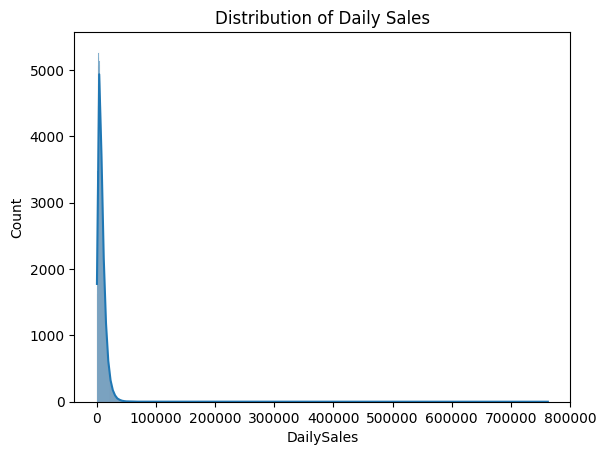

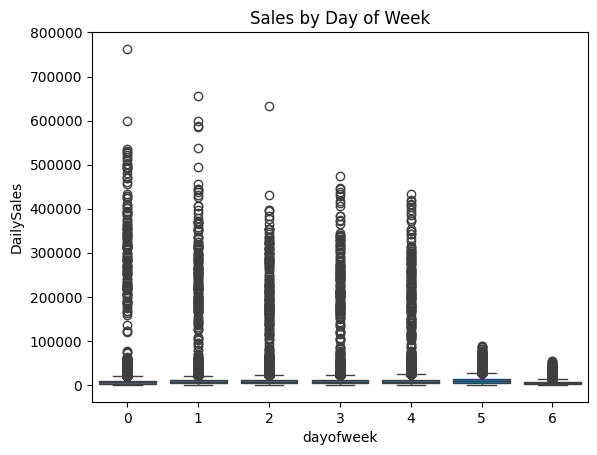

In [ ]:
# Step 4: EDA
sns.histplot(daily_sales['DailySales'].dropna(), kde=True)
plt.title('Distribution of Daily Sales')
plt.show()

sns.boxplot(x='dayofweek', y='DailySales', data=daily_sales)
plt.title('Sales by Day of Week')
plt.show()

In [ ]:
# Step 5: Prepare Data for Modeling
features = ['dayofweek', 'month', 'year', 'lag_1', 'rolling_mean_7']
X = daily_sales[features]
y = daily_sales['DailySales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import joblib

In [ ]:
# Step 6: Train XGBoost with Hyperparameter Tuning
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1]
}
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid,
                           cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

Fitting 3 folds for each of 8 candidates, totalling 24 fits


In [ ]:
import numpy as np
# Step 7: Evaluate Model
y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R2 Score: {r2:.2f}")


MAE: 3150.52, RMSE: 6399.50, R2 Score: 0.85


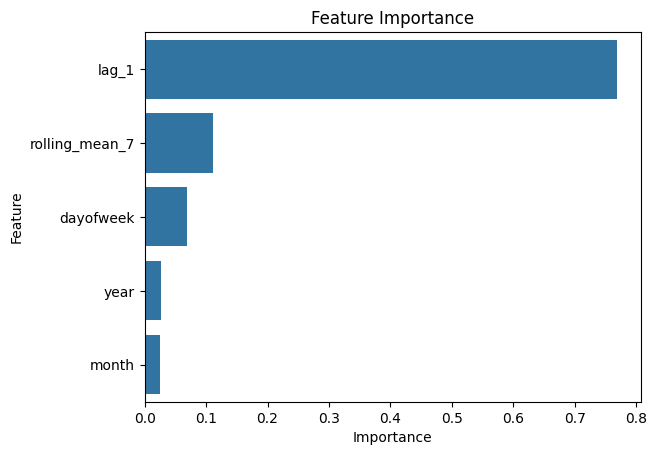

In [ ]:
# Step 8: Feature Importance
importances = best_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()

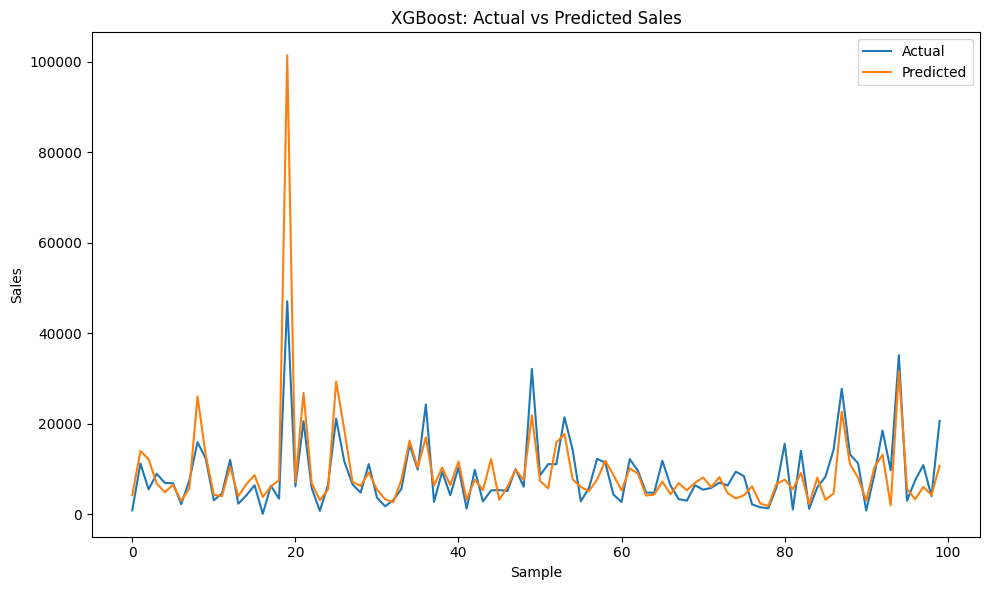

In [ ]:
# Visualize Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test.values[:100], label='Actual')
plt.plot(y_pred[:100], label='Predicted')
plt.title('XGBoost: Actual vs Predicted Sales')
plt.xlabel('Sample')
plt.ylabel('Sales')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Step 10: Forecast Function for Next 7-30 Days

def forecast_sales(branch_id, days_ahead=30):
    assert branch_id in daily_sales['Location ID'].unique(), "Invalid Branch ID"
    recent_data = daily_sales[daily_sales['Location ID'] == branch_id].copy()
    recent_data.sort_values('DealDate', inplace=True)
    last_known = recent_data.iloc[-1:]
    forecast_results = []

    for i in range(1, days_ahead + 1):
        future_date = last_known['DealDate'].values[0] + np.timedelta64(i, 'D')
        dayofweek = future_date.astype('datetime64[D]').astype(object).weekday()
        month = future_date.astype('datetime64[M]').astype(object).month
        year = future_date.astype('datetime64[Y]').astype(object).year

        lag_1 = recent_data['DailySales'].iloc[-1] if not recent_data.empty else 0
        rolling_mean_7 = recent_data['DailySales'].tail(7).mean()

        features = pd.DataFrame([[dayofweek, month, year, lag_1, rolling_mean_7]], columns=['dayofweek', 'month', 'year', 'lag_1', 'rolling_mean_7'])
        pred = best_model.predict(features)[0]

        forecast_results.append({'Date': future_date, 'PredictedSales': pred})

        # Update recent data for next iteration
        recent_data = pd.concat([recent_data, pd.DataFrame({'DealDate': [future_date], 'Location ID': [branch_id], 'DailySales': [pred]})], ignore_index=True)

    return pd.DataFrame(forecast_results)


In [ ]:
# Example usage:
forecast_df = forecast_sales(branch_id=140, days_ahead=30)
print(forecast_df)

         Date  PredictedSales
0  2025-05-01   372966.406250
1  2025-05-02   373044.187500
2  2025-05-03   191123.343750
3  2025-05-04   152884.140625
4  2025-05-05   448159.125000
5  2025-05-06   386182.812500
6  2025-05-07   368126.312500
7  2025-05-08   372966.406250
8  2025-05-09   373044.187500
9  2025-05-10   191123.343750
10 2025-05-11   152884.140625
11 2025-05-12   448159.125000
12 2025-05-13   386182.812500
13 2025-05-14   368126.312500
14 2025-05-15   372966.406250
15 2025-05-16   373044.187500
16 2025-05-17   191123.343750
17 2025-05-18   152884.140625
18 2025-05-19   448159.125000
19 2025-05-20   386182.812500
20 2025-05-21   368126.312500
21 2025-05-22   372966.406250
22 2025-05-23   373044.187500
23 2025-05-24   191123.343750
24 2025-05-25   152884.140625
25 2025-05-26   448159.125000
26 2025-05-27   386182.812500
27 2025-05-28   368126.312500
28 2025-05-29   372966.406250
29 2025-05-30   373044.187500


In [ ]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import joblib



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


XGBoost - MAE: 704.35, RMSE: 1783.50, R2: 0.86
    Actual    Predicted
0  7304.27  2023.844360
1   150.39   242.402542
2   447.24  2205.879883
3    61.10   331.786346
4   408.79   422.559296


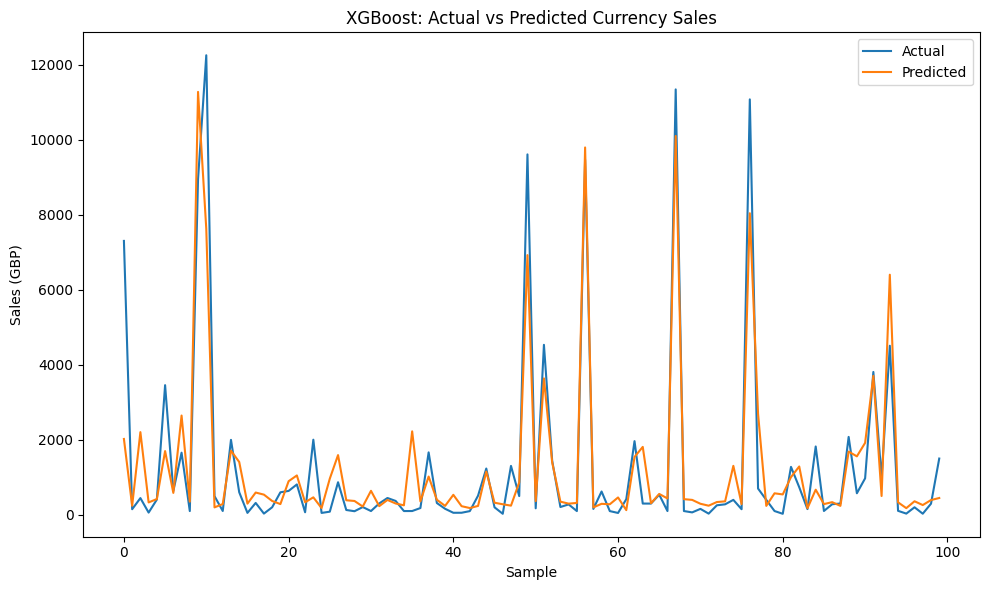

In [ ]:
# Load and preprocess cleaned data
df = pd.read_csv('/content/drive/MyDrive/ML Data 3.csv')
df.columns = df.columns.str.strip()
df.columns.values[4] = 'Currency Type'
df.columns.values[5] = 'Txn Type'
df['Txn Type'] = df['Txn Type'].astype(str).str.strip()
df = df[df['Txn Type'] == 'S']
df['DealDate'] = pd.to_datetime(df['DealDate'], dayfirst=True)

# Step 2: Aggregate Sales by DealDate, Branch, and Currency
currency_sales = df.groupby(['DealDate', 'Location ID', 'Currency'])['Value'].sum().reset_index()
currency_sales.rename(columns={'Value': 'SalesGBP'}, inplace=True)

# Step 3: Feature Engineering
currency_sales['dayofweek'] = currency_sales['DealDate'].dt.dayofweek
currency_sales['month'] = currency_sales['DealDate'].dt.month
currency_sales['year'] = currency_sales['DealDate'].dt.year

# Lag features and rolling means by Branch & Currency
currency_sales['lag_1'] = currency_sales.groupby(['Location ID', 'Currency'])['SalesGBP'].shift(1)
currency_sales['rolling_mean_7'] = currency_sales.groupby(['Location ID', 'Currency'])['SalesGBP'].shift(1).rolling(7).mean()
currency_sales.dropna(inplace=True)

# Step 4: Encode categorical variables
currency_sales = pd.get_dummies(currency_sales, columns=['Currency'], drop_first=True)

# Step 5: Prepare data
features = [col for col in currency_sales.columns if col not in ['DealDate', 'SalesGBP']]
X = currency_sales[features]
y = currency_sales['SalesGBP']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 6: Train XGBoost
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

# Step 7: Evaluate
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print(f"XGBoost - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R2: {r2:.2f}")

# Step 8: Actual vs Predicted DataFrame
results_df = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
results_df.reset_index(drop=True, inplace=True)
print(results_df.head())

# Step 9: Visual Comparison
plt.figure(figsize=(10, 6))
plt.plot(results_df['Actual'][:100], label='Actual')
plt.plot(results_df['Predicted'][:100], label='Predicted')
plt.title('XGBoost: Actual vs Predicted Currency Sales')
plt.xlabel('Sample')
plt.ylabel('Sales (GBP)')
plt.legend()
plt.tight_layout()
plt.show()
